In [43]:
def drop_trials(epochs, chs=1, do_peak=0, do_mean=0, do_slope=0, T1=0, T2=0):
    """
    This function drops trials from the epochs based on criteria such as peak-to-peak amplitude, mean, or slope
    within a time window (T1, T2). Trials that do not meet these criteria are marked for rejection.
    
    Parameters:
        epochs: MNE Epochs object containing trial data.
        chs: Number of channels to process.
        do_peak: Whether to reject trials based on peak amplitude (1 to enable).
        do_mean: Whether to reject trials based on mean amplitude (1 to enable).
        do_slope: Whether to reject trials based on signal slope (1 to enable).
        T1, T2: Time window for processing the trials.
        
    Returns:
        new_epochs: Updated epochs with dropped trials.
        peak_rejection, mean_rejection, slope_rejection: Counters for rejected trials.
        list_trials: List indicating which trials were kept (1) or rejected (0).
    """
    # Make a copy of the epochs data
    new_epochs = epochs.copy()
    list_trials = np.ones(len(new_epochs))  # Initialize a list to mark good trials

    for j in range(chs):
        peak_rejection, mean_rejection, slope_rejection = 0, 0, 0  # Initialize rejection counters

        # Rejection based on peak amplitude
        if do_peak == 1:
            # Find time indices for the rejection window
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]

            # Compute peak-to-peak values for each trial and channel
            peak_to_peak = np.array([max(new_epochs._data[i][j][time1:time2]) - min(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))
            Q1, Q3 = np.nanquantile(peak_to_peak, [.25, .75])
            outlier_up_peak = Q3 + (2 * iqr(peak_to_peak, nan_policy='omit'))

            idx = [i for i, value in enumerate(peak_to_peak) if value > outlier_up_peak]  # Find outlier trials

            peak_to_peak[idx] = None  # Mark the outliers
            list_trials[idx] = 0  # Mark trials for rejection
            peak_rejection += len(idx)

        # Rejection based on slope
        if do_slope == 1:
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]
            x = new_epochs.times[time1:time2]

            # Calculate slope for each trial
            slopes_trials = np.array([np.polyfit(x, new_epochs._data[i, j, time1:time2], 1)[0] for i in range(len(new_epochs._data))], dtype=np.dtype(float))

            Q1, Q3 = np.nanquantile(slopes_trials, [.25, .75])
            outlier_up_mean = Q1 + (2 * iqr(slopes_trials, nan_policy='omit'))
            outlier_down_mean = Q3 - (2 * iqr(slopes_trials, nan_policy='omit'))

            idx = [i for i, value in enumerate(slopes_trials) if value > outlier_up_mean or value < outlier_down_mean]

            slopes_trials[idx] = None
            list_trials[idx] = 0  # Mark trials for rejection
            slope_rejection += len(idx)

        # Rejection based on mean amplitude
        if do_mean == 1:
            time1 = np.where(new_epochs.times < T1)[0][-1]
            time2 = np.where(new_epochs.times < T2)[0][-1]
            mean_trials = np.array([np.mean(new_epochs._data[i][j][time1:time2]) for i in range(len(new_epochs._data))], dtype=np.dtype(float))

            Q1, Q3 = np.nanquantile(mean_trials, [.25, .75])
            outlier_up_mean = Q3 + (2 * iqr(mean_trials, nan_policy='omit'))
            outlier_down_mean = Q1 - (2 * iqr(mean_trials, nan_policy='omit'))

            idx = [i for i, value in enumerate(mean_trials) if value > outlier_up_mean or value < outlier_down_mean]

            mean_trials[idx] = None
            list_trials[idx] = 0  # Mark trials for rejection
            mean_rejection += len(idx)

    # Drop the rejected trials and return the updated epochs
    new_epochs.drop(np.where(list_trials == 0)[0])
    return new_epochs, peak_rejection, mean_rejection, slope_rejection, list_trials


In [8]:
# Import the required libraries
import os, mne, csv
import numpy as np
import pandas as pd 
from mne.channels import make_standard_montage
from glob import glob
from scipy import stats
from scipy.stats import iqr, median_abs_deviation as mad
from mne.time_frequency import tfr_morlet

# Set the directory where the data is located
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives')

# Get a list of raw EEG files names
data_files = glob('*_raw.fif')


In [4]:
%%capture
# Define variables to store participant information and drop statistics
participant = {}
drop_stats = []
# Define variables to store participant information and drop statistics
participant = {}
drop_stats = []

# Loop over the EEG files
for part_i, part in enumerate(data_files):
    try:
        # Extract participant number and load the raw EEG data
        n_part = part.split("sub-")[1].split("_")[0]
        raw = mne.io.read_raw_fif(part, preload=True)

        if part_i == 0:
            # Create the forward model (sphere) for source localization
            sphere = mne.make_sphere_model('auto', 'auto', raw.info)
            src = mne.setup_volume_source_space(sphere=sphere)
            forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)

        # Set the EEG reference to REST (Reference Electrode Standardization Technique)
        raw.set_eeg_reference('REST', forward=forward)

        # Define event labels for different conditions
        event_dict_selection = {
            'selection/forced/authority/yes': 19, 'selection/forced/authority/no': 20,
            'selection/forced/group/yes': 21, 'selection/forced/group/no': 22,
            'selection/forced/indiv/yes': 23, 'selection/forced/indiv/no': 24,
            'selection/free/authority/yes': 25, 'selection/free/authority/no': 26,
            'selection/free/group/yes': 27, 'selection/free/group/no': 28,
            'selection/free/indiv/yes': 29, 'selection/free/indiv/no': 30
        }

        # Handle custom event selections for specific participants
        if n_part == '170':  # No selection for 'indiv yes free'
            event_dict_selection.pop('selection/free/indiv/yes')
        if n_part == '936':  # No selection for 'indiv no free'
            event_dict_selection.pop('selection/free/indiv/no')

        # Extract events from annotations and define epochs
        events, _ = mne.events_from_annotations(raw, event_dict_selection)
        epochs = mne.Epochs(raw, events, event_id=event_dict_selection, tmin=-2.5, tmax=2.5,
                            picks=['Fz', 'Cz', 'FC1', 'FC2'], baseline=None, preload=True)

        # Combine channels into one average
        event_id = epochs.event_id
        epochs = mne.channels.combine_channels(epochs, dict(Avg=list(range(len(epochs.info['chs'])))))
        epochs.event_id = event_id

        # Apply baseline correction (in this case between 1 and 1.5 seconds)
        epochs.apply_baseline((1, 1.5))

        # Drop bad trials using custom drop criteria (mean, peak, slope)
        epochs, _, _, _, list_ti = drop_trials(epochs, do_mean=1, do_peak=1, do_slope=0,
                                               T1=-1.5, T2=1.5, chs=len(epochs.ch_names))

        # Time-frequency analysis (Morlet wavelet transform)
        freqs = np.logspace(np.log10(2), np.log10(30), num=80)
        n_cycles = np.logspace(np.log10(4), np.log10(14), 80)
        power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False, return_itc=False)

        # Save the power data (time-frequency representation)
        power.save(part.split('raw.fif')[0] + 'tfr.h5', overwrite=True)

        # Collect drop statistics
        drop_stats.append(epochs.drop_log_stats()) 
    except :
        participant[part] = [part_i, "Trouble"]


In [1]:
%%capture
# Import the required libraries
import os, mne, csv
import numpy as np
from glob import glob

#set directory pathway
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives_with_tfr/')
data_files = glob('*_tfr.h5')
all_evokeds = []  # Dictionary to store evoked data for all conditions
drop_stats = []  # List to store drop statistics
participant_n = []
# Iterate over data files
for part_i,part in enumerate(data_files):
# for part in range(30):
    power = mne.time_frequency.read_tfrs(part)
    all_evokeds.append(power.crop(-1.6,1.6))
    n_part = part.split("sub-")[1].split("_")[0]
    if int(n_part)<500:
        participant_n.append("Belgium")
    elif int(n_part)<800:
        participant_n.append("Cambodia")
    else :
        participant_n.append("Rwanda")
    if int(n_part) in [179, 740, 945, 950, 956]:
        participant_n[-1] = "Bad_part"
        
    drop_stats.append((power.drop_log.count(('USER',))/len(power.drop_log))*100)


No baseline correction applied


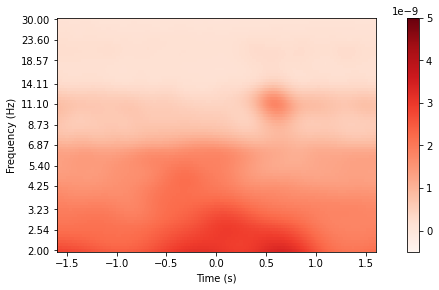

[<Figure size 432x288 with 2 Axes>]

In [15]:
power.average().plot(vlim=[-.5e-9,5e-9])

In [2]:
for power in all_evokeds: 

    chs=0
    imin_baseline = np.where(power.times<=.5)[0][-1]
    imax_baseline = np.where(power.times<=1.5)[0][-1]
    imin = np.where(power.times<=-1.5)[0][-1]
    imax = np.where(power.times<=1.5)[0][-1]
    for n_trial in range(len(power)):
        data= power._data[n_trial,...]
        mean = np.mean(data[...,imin:imax],axis=-1,keepdims=True)
        std = np.std(data[...,imin:imax],axis=-1,keepdims=True)
        data-=mean
        data /= std


    power_avg = power.average()
    mean_avg = np.mean(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)
    std_avg = np.std(power_avg._data[...,imin_baseline:imax_baseline],axis=-1,keepdims=True)
    
    for n_trial in range(len(power)):
        data= power._data[n_trial,...]
        data-=mean_avg
        data /= std_avg

In [3]:
%%capture
# Compute the grand average of time-frequency data across conditions and participants
gr_evok = mne.grand_average([part.average()
                            for i,part in enumerate(all_evokeds)],
                        interpolate_bads=True)

In [4]:
%%capture
# Statistical thresholds for significance (z-scores)
p01, p005, p001 = [1.65, 1.96, 2.58]

# Calculate upper and lower significance thresholds using the 95% confidence interval
gr_evok_copy=gr_evok.copy().crop(-1.5, 1.5)
signif_up = np.mean(gr_evok_copy.data) + (p005 * np.std(gr_evok_copy.data))
signif_down = np.mean(gr_evok_copy.data) - (p005 * np.std(gr_evok_copy.data))

gr_evok_copy=gr_evok.copy()

# Mark significant data points
gr_evok_copy.data[gr_evok_copy.data < signif_down] = 100
gr_evok_copy.data[gr_evok_copy.data > signif_up] = 100

# Create a mask for plotting significant areas
mask = gr_evok_copy.data ==False
mask[gr_evok_copy.data==100]= True
mask[0,np.where(gr_evok.freqs<=7)[0][-1]:,:]= False


No baseline correction applied


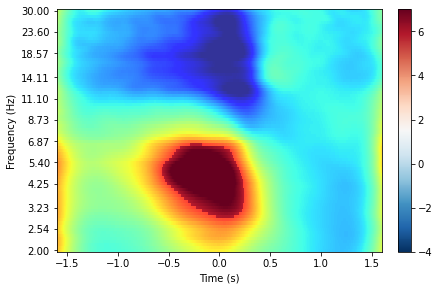

[<Figure size 432x288 with 2 Axes>]

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

gr_evok.plot(vlim=(-4,7), mask=np.squeeze(mask), cmap="RdBu_r" ,mask_cmap='jet', mask_alpha=.8, mask_style="contour")


In [20]:


# Change directory to save the mask (if needed)
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/results')

# save mask
np.save("mask.npy", mask)

mask = np.load("mask.npy")  # Load a predefined mask if available

array([25, 63, 68, 74], dtype=int64)

0
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\2803652708.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


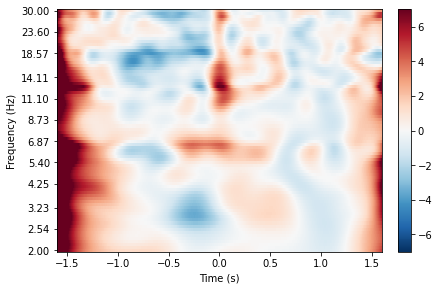

1
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\2803652708.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


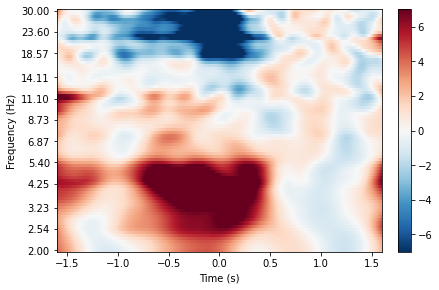

2
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\2803652708.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  part.copy().average().plot(vmin=vmin ,vmax=vmax)


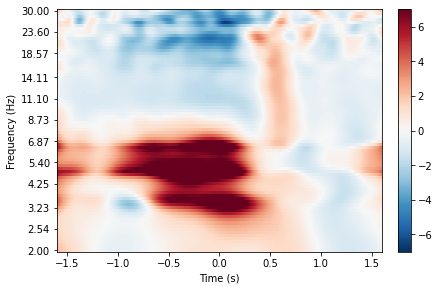

In [24]:
%matplotlib inline
# Visualize individual participants (optional)
vmin=-7; vmax=7

for i, part in enumerate(all_evokeds):
    if i <3 :
        print(i)
        part.copy().average().plot(vmin=vmin ,vmax=vmax)


In [25]:
# Remove bad participants from the analysis
all_evokeds_clean = np.delete(
    all_evokeds, np.where(np.array(participant_n) == "Bad_part")
)

c:\Program Files\Anaconda3\envs\eeg\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [26]:

# Compute grand averages for 'yes' and 'no' responses in Belgium and Rwanda
Yes_Belgium = mne.grand_average([
    part["yes"].copy().average()
    for part_i, part in enumerate(all_evokeds_clean)
    if participant_n[part_i] == "Belgium"
])
No_Belgium = mne.grand_average([
    part["no"].copy().average()
    for part_i, part in enumerate(all_evokeds_clean)
    if participant_n[part_i] == "Belgium"
])
Yes_Rwanda = mne.grand_average([
    part["yes"].copy().average()
    for part_i, part in enumerate(all_evokeds_clean)
    if participant_n[part_i] == "Rwanda"
])
No_Rwanda = mne.grand_average([
    part["no"].copy().average()
    for part_i, part in enumerate(all_evokeds_clean)
    if participant_n[part_i] == "Rwanda"
])

# Compute the difference between 'no' and 'yes' conditions
dif_belgium = No_Belgium.copy()
dif_belgium._data -= Yes_Belgium._data
dif_Rwanda = No_Rwanda.copy()
dif_Rwanda._data -= Yes_Rwanda._data

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:3: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


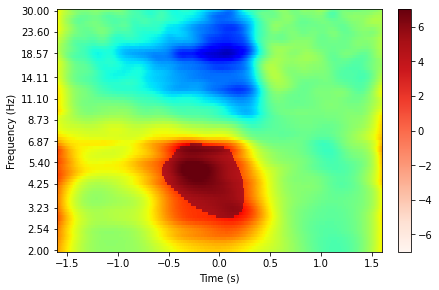

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:4: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No_Belgium.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


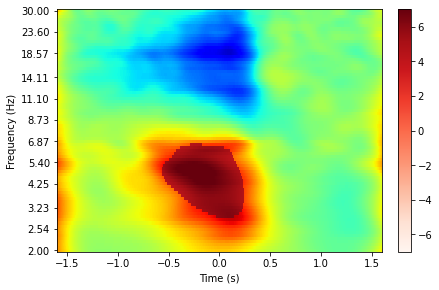

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:5: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_belgium.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


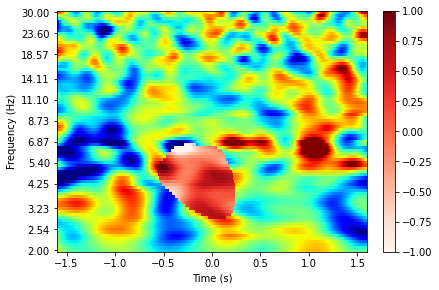

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:6: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(Yes_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


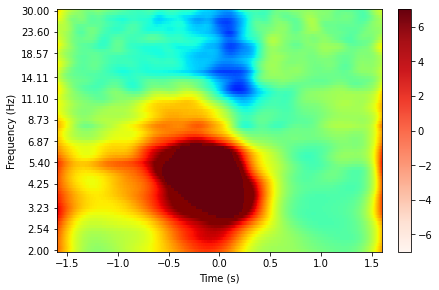

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:7: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(No_Rwanda.plot(vmin=vmin ,vmax=vmax,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


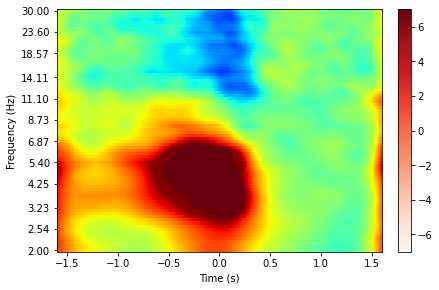

[<Figure size 432x288 with 2 Axes>]
No baseline correction applied


C:\Users\mfbpe\AppData\Local\Temp\ipykernel_10476\596277306.py:8: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  print(dif_Rwanda.plot(vmin=vmin_dif ,vmax=vmax_dif,  cmap='Reds', mask_cmap='jet',mask=np.squeeze(mask), mask_alpha=1))


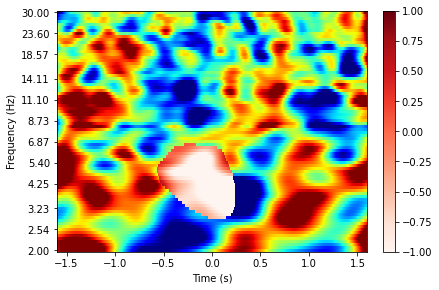

[<Figure size 432x288 with 2 Axes>]


In [29]:

# Plot the results for Belgium and Rwanda
vmin_dif = -1
vmax_dif = 1
print(Yes_Belgium.plot(
    vmin=vmin, vmax=vmax, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))
print(No_Belgium.plot(
    vmin=vmin, vmax=vmax, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))
print(dif_belgium.plot(
    vmin=vmin_dif, vmax=vmax_dif, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))
print(Yes_Rwanda.plot(
    vmin=vmin, vmax=vmax, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))
print(No_Rwanda.plot(
    vmin=vmin, vmax=vmax, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))
print(dif_Rwanda.plot(
    vmin=vmin_dif, vmax=vmax_dif, cmap='Reds', mask_cmap='jet',
    mask=np.squeeze(mask), mask_alpha=1
))

In [180]:

# Change directory to save results
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/results')

# Open a CSV file to write extracted data for statistical analysis
datafile = open("SIV2_Cambodia_eeg_lmer_005sign_base500ms_1500ms.csv", "w", newline="")

# Create a CSV writer object
writer = csv.writer(datafile, delimiter=";")

# Write the header row to the CSV file
writer.writerow([
    "Participant",
    "Trial",
    "Outlier",
    "RT", 
    "Forced_free",
    "Influence",
    "answer",
    "FMtheta"
])


67

In [153]:

# Import necessary libraries (if not already imported)
import os, mne, csv
import numpy as np
import pandas as pd
from mne.channels import make_standard_montage
from glob import glob
from scipy import stats
from scipy.stats import iqr, median_abs_deviation as mad
from mne.time_frequency import tfr_morlet

# Set the directory path where the EEG data files are located
os.chdir('C:/Users/mfbpe/Desktop/DATA/2023_Social_Influence/derivatives')

# Get a list of all raw EEG data files
data_files = glob('*_raw.fif')

# Loop over each data file (participant)
for part_i, part in enumerate(data_files):
    # Extract the participant number
    n_part = part.split("sub-")[1].split("_")[0]
    if n_part != '740':  # Exclude participant 740
        # Load the raw EEG data
        raw = mne.io.read_raw_fif(part, preload=True)

        if part_i == 0:
            # For the first participant, create a sphere model and compute the forward solution
            sphere = mne.make_sphere_model('auto', 'auto', raw.info)
            src = mne.setup_volume_source_space(sphere=sphere)
            forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        # Set the EEG reference using the REST method
        raw.set_eeg_reference('REST', forward=forward)

        # Define event dictionaries for visualization and selection
        event_dict_vizualization = {
            'vizualisation/forced/authority/yes': 1,
            'vizualisation/forced/authority/no': 2,
            'vizualisation/forced/group/yes': 3,
            'vizualisation/forced/group/no': 4,
            'vizualisation/forced/indiv/yes': 5,
            'vizualisation/forced/indiv/no': 6,
            'vizualisation/free/authority-yes/group-yes': 7,
            'vizualisation/free/authority-yes/group-no': 8,
            'vizualisation/free/authority-no/group-yes': 11,
            'vizualisation/free/authority-yes/indiv-yes': 9,
            'vizualisation/free/authority-yes/indiv-no': 10,
            'vizualisation/free/authority-no/group-no': 12,
            'vizualisation/free/authority-no/indiv-yes': 13,
            'vizualisation/free/authority-no/indiv-no': 14,
            'vizualisation/free/group-yes/indiv-yes': 15,
            'vizualisation/free/group-yes/indiv-no': 16,
            'vizualisation/free/group-no/indiv-yes': 17,
            'vizualisation/free/group-no/indiv-no': 18
        }
        event_dict_selection = {
            'selection/forced/authority/yes': 19,
            'selection/forced/authority/no': 20,
            'selection/forced/group/yes': 21,
            'selection/forced/group/no': 22,
            'selection/forced/indiv/yes': 23,
            'selection/forced/indiv/no': 24,
            'selection/free/authority/yes': 25,
            'selection/free/authority/no': 26,
            'selection/free/group/yes': 27,
            'selection/free/group/no': 28,
            'selection/free/indiv/yes': 29,
            'selection/free/indiv/no': 30
        }

        # Adjust the event dictionary for participants with missing conditions
        if n_part == '170':  # No 'selection/free/indiv/yes'
            event_dict_selection.pop('selection/free/indiv/yes')
        if n_part == '936':  # No 'selection/free/indiv/no'
            event_dict_selection.pop('selection/free/indiv/no')

        # Merge the event dictionaries
        event_dict = {**event_dict_vizualization, **event_dict_selection}
        # Extract events from annotations
        events, event_dict = mne.events_from_annotations(raw, event_dict)

        # Create epochs for visualization events (short time window)
        epochs_visualization = mne.Epochs(
            raw, events, baseline=None, event_id=event_dict_vizualization,
            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-0.1, tmax=0.1, reject_by_annotation=False,
            preload=True, detrend=None, event_repeated='drop', on_missing='ignore'
        )

        # Create epochs for selection events (short time window)
        epochs_selection = mne.Epochs(
            raw, events, baseline=None, event_id=event_dict_selection,
            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-0.1, tmax=0.1, reject_by_annotation=False,
            preload=True, detrend=None, event_repeated='drop', on_missing='ignore'
        )

        # Calculate reaction times (RT) between visualization and selection events
        if n_part in ['155', '184']:
            RT = [None]  # Initialize with None for the first trial
            RT += [
                round((epochs_selection.events[x + 1, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events))
            ]
        elif n_part == "168":
            RT = [
                round((epochs_selection.events[x, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events)) if x < 439
            ]
            RT += [None] + [
                round((epochs_selection.events[x + 1, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events)) if x > 438
            ]
        elif n_part == "936":
            # Equalize the number of epochs and calculate RT
            mne.epochs.equalize_epoch_counts([epochs_selection, epochs_visualization])
            RT = [None]
            RT += [
                round((epochs_selection.events[x + 1, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_selection.events) - 1)
            ]
        elif n_part == "164":
            RT = [
                round((epochs_selection.events[x, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events)) if x < 14
            ]
            RT += [None] + [
                round((epochs_selection.events[x + 1, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events)) if x > 13
            ]
        else:
            RT = [
                round((epochs_selection.events[x, 0] - epochs_visualization.events[x, 0]) / 512, 2)
                for x in range(len(epochs_visualization.events))
            ]

        # Create epochs for selection events (long time window)
        epochs_selection = mne.Epochs(
            raw, events, baseline=None, event_id=event_dict_selection,
            picks=['Fz', 'Cz', 'FC1', 'FC2'], tmin=-2.5, tmax=2.5, reject_by_annotation=False,
            preload=True, detrend=None, event_repeated='drop', on_missing='ignore'
        )

        # Combine channels into an average
        event_id = epochs_selection.event_id
        epochs_selection = mne.channels.combine_channels(
            epochs_selection, dict(Avg=list(range(len(epochs_selection.info['chs']))))
        )
        epochs_selection.event_id = event_id

        # Apply baseline correction
        epochs_selection.apply_baseline((1, 1.5))

        # Drop trials based on mean and peak criteria
        epochs_clean, _, _, _, list_ti, _ = drop_trials(
            epochs_selection, do_mean=1, do_peak=1, do_slope=0,
            T1=-1.5, T2=1.5, chs=list(range(len(epochs_selection.info['chs'])))
        )

        # Define frequencies and cycles for time-frequency analysis
        freqs = np.logspace(np.log10(2), np.log10(30), num=80)
        n_cycles = np.logspace(np.log10(4), np.log10(14), 80)

        # Compute time-frequency representation on cleaned epochs
        power = tfr_morlet(
            epochs_clean, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
            return_itc=False, n_jobs=-1
        )

        # Baseline correction for each trial
        chs = 0
        imin_baseline = np.where(power.times <= 0.5)[0][-1]
        imax_baseline = np.where(power.times <= 1.5)[0][-1]
        imin = np.where(power.times <= -1.5)[0][-1]
        imax = np.where(power.times <= 1.5)[0][-1]
        for n_trial in range(len(power)):
            data = power._data[n_trial, ...]
            mean = np.mean(data[..., imin:imax], axis=-1, keepdims=True)
            std = np.std(data[..., imin:imax], axis=-1, keepdims=True)
            data -= mean
            data /= std

        # Compute average baseline
        power_avg = power.average()
        mean_avg = np.mean(power_avg._data[..., imin_baseline:imax_baseline], axis=-1, keepdims=True)
        std_avg = np.std(power_avg._data[..., imin_baseline:imax_baseline], axis=-1, keepdims=True)

        # Recompute power on the original epochs (including dropped trials)
        power = tfr_morlet(
            epochs_selection, freqs=freqs, n_cycles=n_cycles, use_fft=True, average=False,
            return_itc=False, n_jobs=-1
        )
        power.crop(-1.6, 1.6)

        # Baseline correction for each trial using the average baseline
        for n_trial in range(len(power)):
            data = power._data[n_trial, ...]
            mean = np.mean(data[..., imin:imax], axis=-1, keepdims=True)
            std = np.std(data[..., imin:imax], axis=-1, keepdims=True)
            data -= mean
            data /= std

        list_trigger = [
            list(event_dict_selection.keys())[list(event_dict_selection.values()).index(power.events[x, 2])].split("/")
            for x in range(len(power))
        ]

        # Extract FMtheta values and write to CSV
        for n_trial in range(len(power)):
            data = power._data[n_trial, ...]
            data -= mean_avg
            data /= std_avg
            FMtheta = np.mean(data[mask])

            writer.writerow([
                n_part,
                n_trial + 1,
                list_ti[n_trial],
                RT[n_trial],
                list_trigger[n_trial][1],
                list_trigger[n_trial][2],
                list_trigger[n_trial][3],
                round(FMtheta, 3)
            ])
            datafile.flush()

# Close the CSV file
datafile.close()